# A Cat/Dog classifier

Here we will try to train a cat/dog classifiers with images of higher-resolution images than we got from the CIFA10 dataset.

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/sw/apps/python3/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data
First we load some prepared images of cats and dogs and split the data into training and test sets and make sure we have equal numbers of cats and dogs.

4561  images in total
2168  cats,  2393  dogs; using  2168  of each


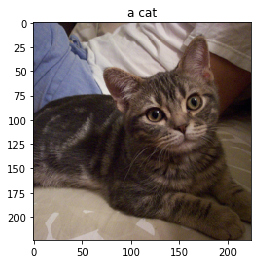

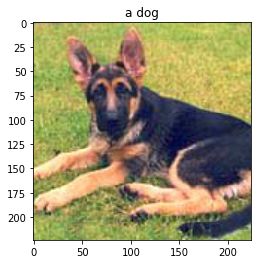

In [2]:
DATAFILE="../../../data/catsDogsImageNet.npz"
with np.load(DATAFILE) as datafile:
    ncats = np.where(datafile["label"]==0)[0].size
    ndogs = np.where(datafile["label"]==1)[0].size
    neach = min(ncats, ndogs)
    print(datafile["data"].shape[0], " images in total")
    print(ncats, " cats, ", ndogs, " dogs; using ", neach, " of each")
    data = np.concatenate((datafile['data'][0:neach], datafile['data'][ncats:ncats+neach]))
    data = data /255.
    dataAverage = np.average(data, axis=0)
    #data -= dataAverage
    labels = np.concatenate((np.zeros(neach), np.ones(neach)))
    
    plt.imshow(data[0])
    plt.title("a cat")
    plt.show()
    plt.imshow(data[ncats])
    plt.title("a dog")
    plt.show()
    
selection = np.random.permutation(data.shape[0])
split = int(len(selection)*.7)
x_train = data[selection[:split]]
y_train = labels[selection[:split]]
x_test = data[selection[split:]]
y_test = labels[selection[split:]]
del labels

# traning data is augmented
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

batch_size=32
input_shape=x_train.shape[1:]

train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

In this case the we only have ~4500 images and these contain more potentially useless information as they are larger. To metigate this to an extent we use data augmentation from the start.

The next Cell defines parameters we use for training our networks and defines functions which we will use later to print our results.

In [3]:
def predict(idx, model, avg=None, norm=255, cols=3, file=DATAFILE, data=None, threshold=.4):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    cats = 0
    dogs = 0
    if data is None:
        with np.load(file) as datafile:
            data = datafile["data"][idx]
    else:
        data = data[idx]
    if norm is None:
        p = model.predict(data)
    else:
        p = model.predict(data/norm)
    i = 0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(8*cols,8))
        fig.figsize=(20,10)
        for ax in axs:
            if avg is not None:
                img = (data[i]+avg)
            else:
                img = (data[i])

            ax.imshow(img)
            if p[i] < threshold:
                label = "cat"
                cats += 1
            elif p[i] > 1-threshold:
                label = "dog"
                dogs += 1
            else:
                label = "not sure"
            ax.text(.5,0, label+ "; score = " + str(p[i]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()
    print(cats, " cats (", cats/len(idx)*100., "%),", dogs, " dogs (", dogs/len(idx)*100., "%)")
    
def predictCategorical(idx, model, decode=lambda x : str(x), preproc=lambda x : x/255.
                       , cols=3, file=DATAFILE, data=None):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    if data is None:
        with np.load(file) as datafile:
            data = datafile["data"][idx]
    else:
        data = data[idx]
        
    p = model.predict(data if preproc is None else preproc(data))
    
    i=0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(8*cols,8))
        fig.figsize=(20,10)
        for ax in axs:
            ax.imshow(data[i])
            ax.text(.5,0, decode(p[i:i+1]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()

### A Rather Simple Network

Next, we define an train a rather simple network to tell cats from dogs. We used this one before on the CIFAR 10 data and it got us to about 80% accuracy there.

In [5]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2), input_shape=input_shape))
model.add(Conv2D(48, kernel_size=(5, 5),
                 activation='relu', padding="same"))
model.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(96, (5, 5), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(160, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model.add(Flatten())
model.add(Dropout(.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

opt = keras.optimizers.adam(lr=0.0001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# model.summary()

In [6]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 // batch_size,
        epochs=10,
        validation_data=(x_test, y_test))

# model.save_weights('weights.h5')
# model.load_weights('weights.h5')

Epoch 1/10
125/125 [==============================] - 49s 392ms/step - loss: 0.7261 - acc: 0.6098 - val_loss: 0.5931 - val_acc: 0.6856
Epoch 2/10
125/125 [==============================] - 46s 365ms/step - loss: 0.6354 - acc: 0.6610 - val_loss: 0.5667 - val_acc: 0.7141
Epoch 3/10
125/125 [==============================] - 47s 372ms/step - loss: 0.5803 - acc: 0.6972 - val_loss: 0.5350 - val_acc: 0.7317
Epoch 4/10
125/125 [==============================] - 47s 376ms/step - loss: 0.5518 - acc: 0.7241 - val_loss: 0.5828 - val_acc: 0.7271
Epoch 5/10
125/125 [==============================] - 46s 369ms/step - loss: 0.5410 - acc: 0.7407 - val_loss: 0.4867 - val_acc: 0.7733
Epoch 6/10
125/125 [==============================] - 46s 366ms/step - loss: 0.5240 - acc: 0.7418 - val_loss: 0.6173 - val_acc: 0.6626
Epoch 7/10
125/125 [==============================] - 46s 370ms/step - loss: 0.4984 - acc: 0.7578 - val_loss: 0.5365 - val_acc: 0.7617
Epoch 8/10
125/125 [==============================] - 4

After ten epochs we see a validation accuray a bit over 70% and a few more epoch may get this up to ~80% again.

Now, let us have a look at the results this network give on a few images and the corresponding predictions.

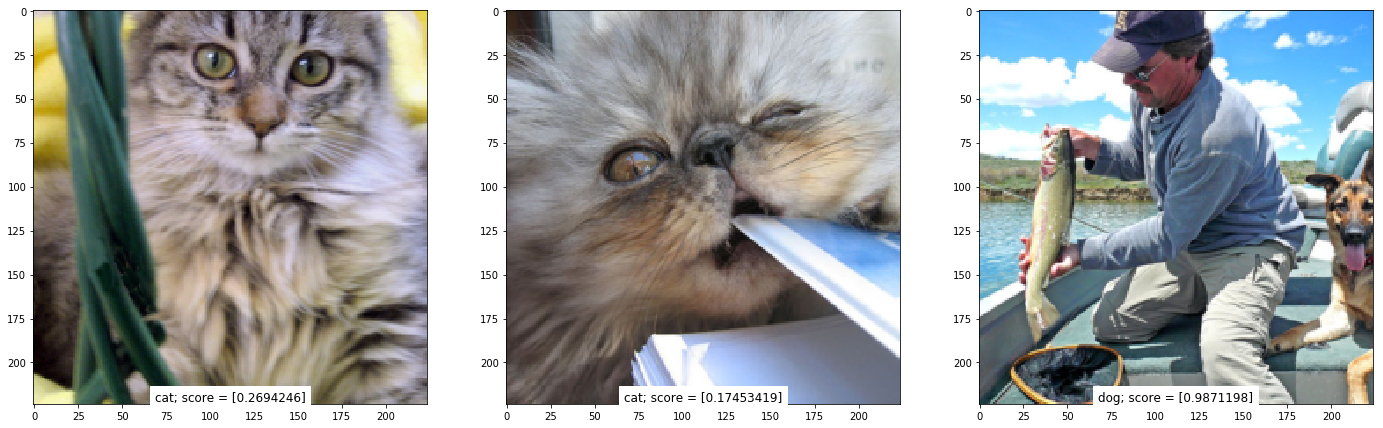

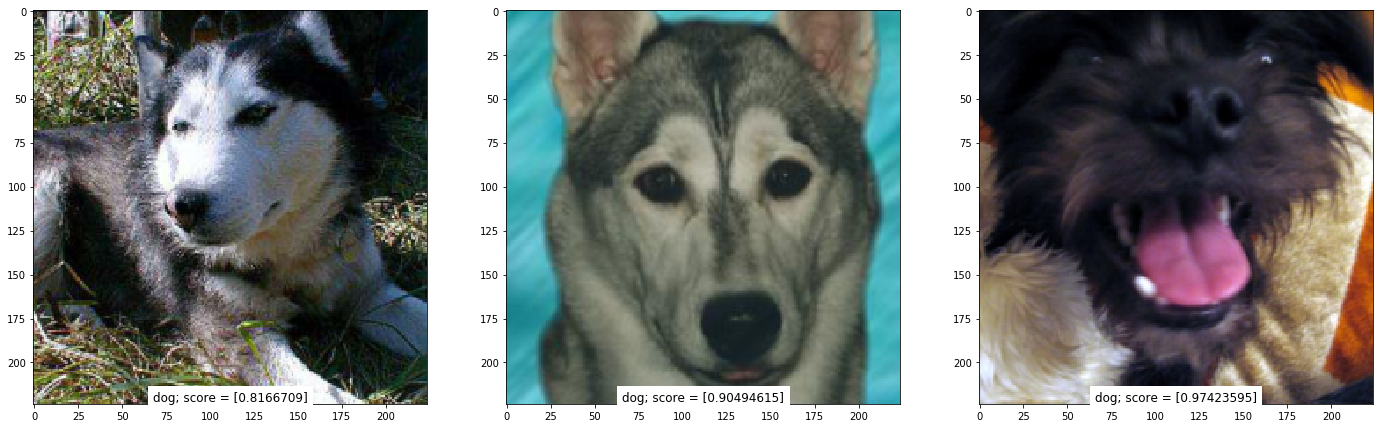

2  cats ( 33.33333333333333 %), 4  dogs ( 66.66666666666666 %)


In [7]:
# some arbitrary selection from the data
predict([1,2000,3000,4000,4300,4510], model)

This network is not very good, but decent, given, that some of the training images are rather complex.

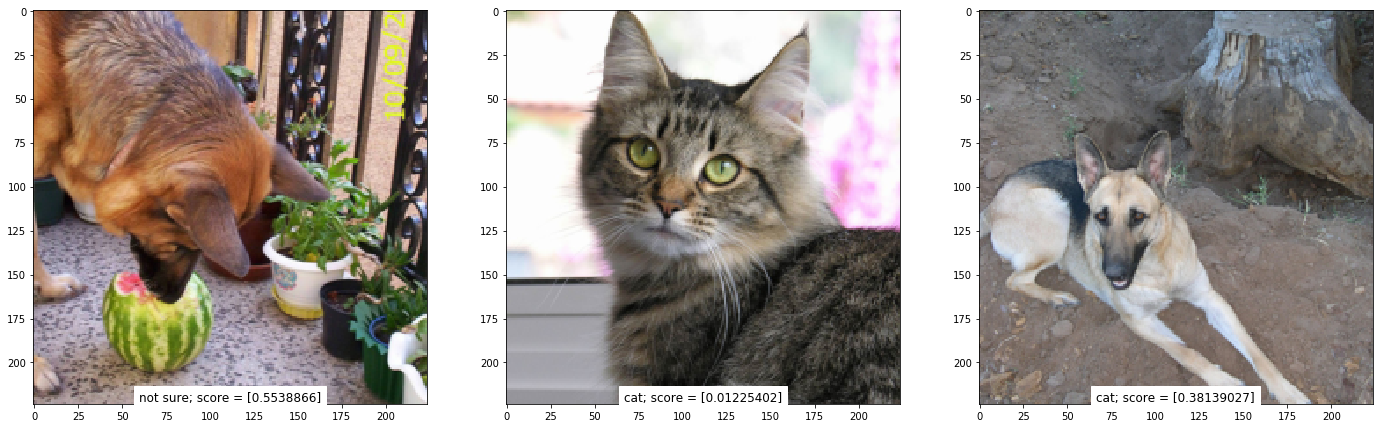

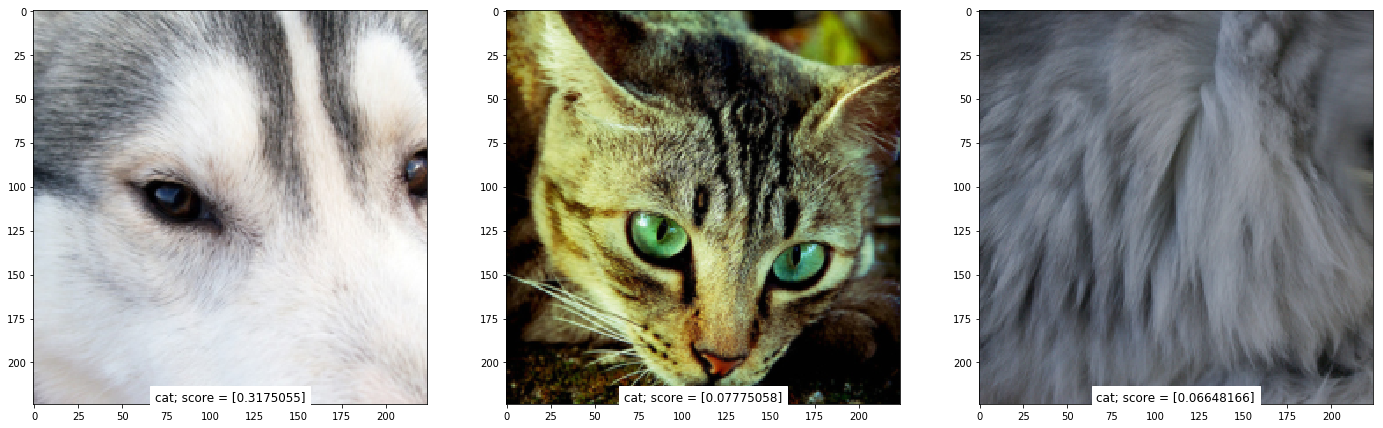

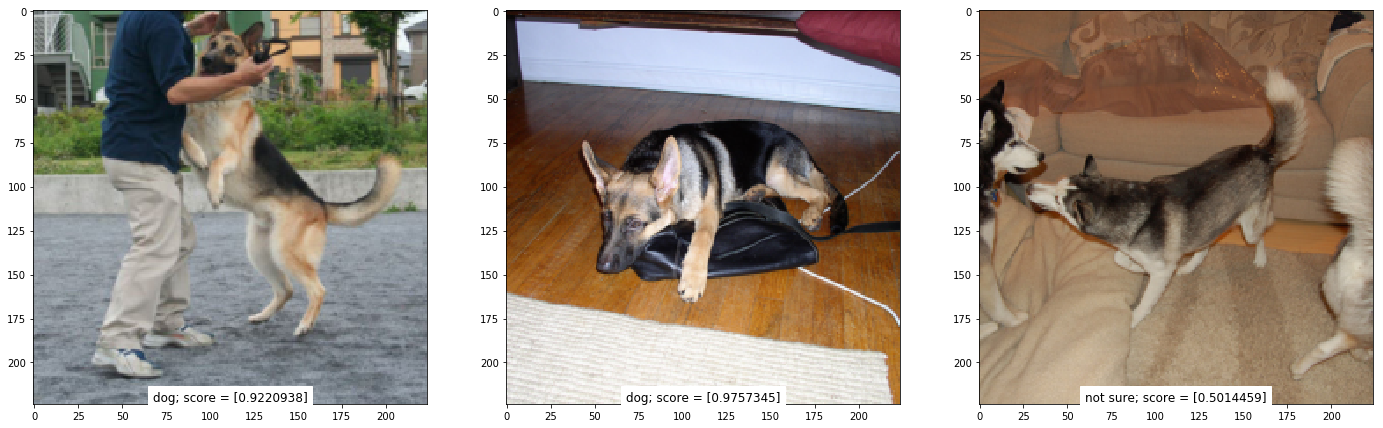

5  cats ( 55.55555555555556 %), 2  dogs ( 22.22222222222222 %)


In [8]:
# some of the training images
predict(range(9), model, data=x_train, norm=None)

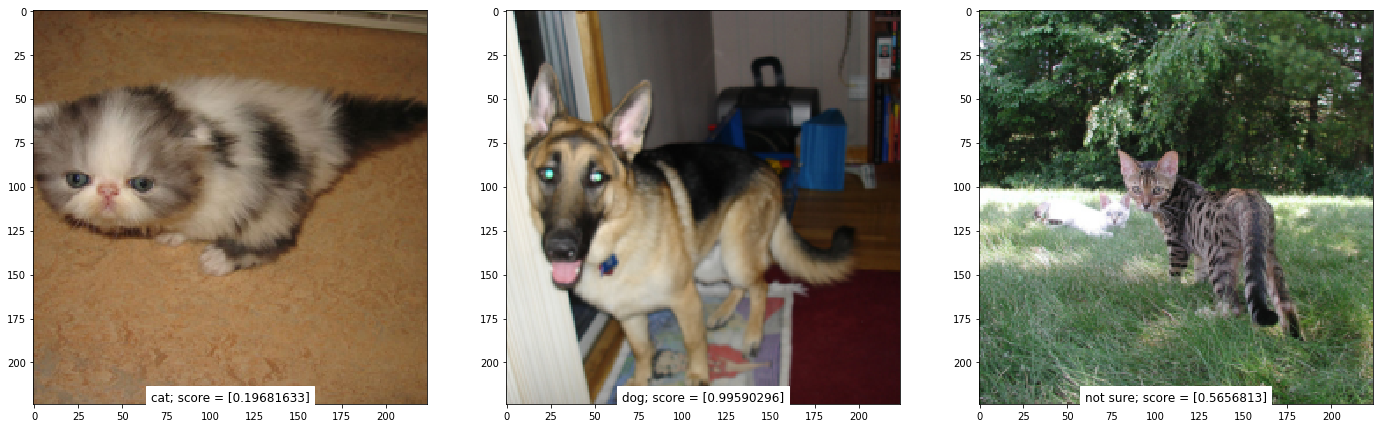

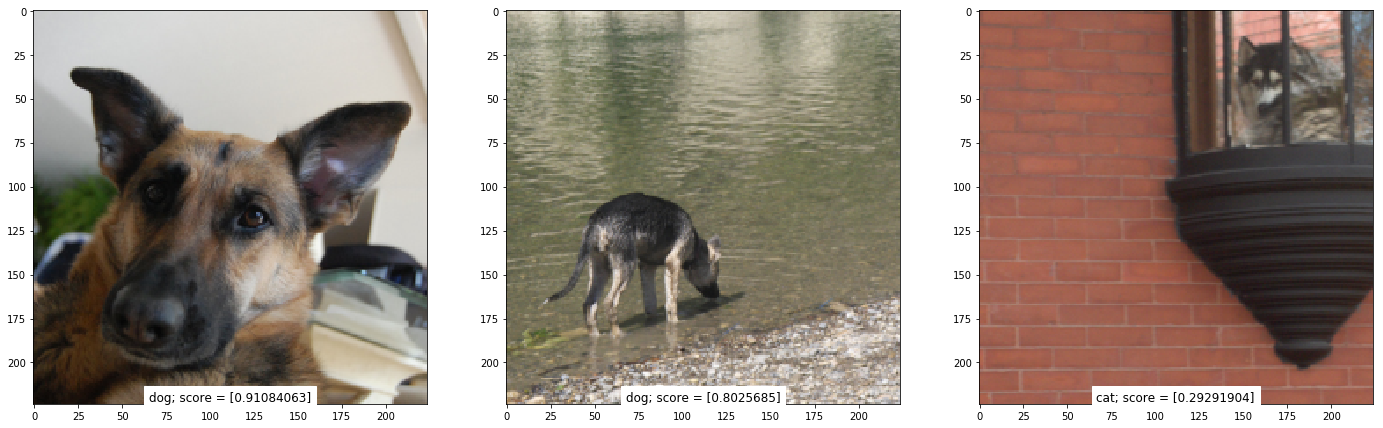

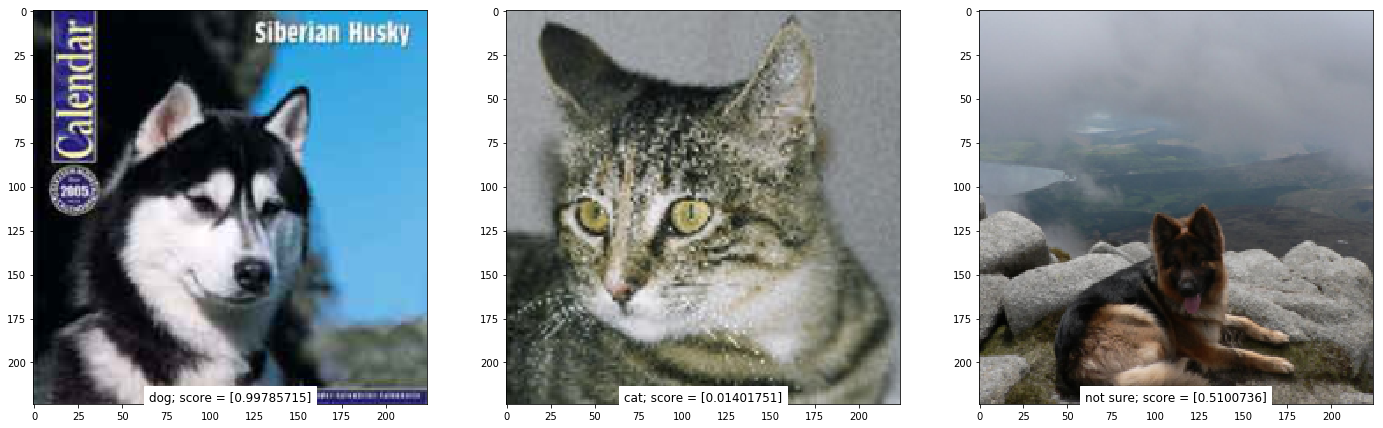

3  cats ( 33.33333333333333 %), 4  dogs ( 44.44444444444444 %)


In [9]:
# some of the validation images
predict(range(9), model, data=x_test, norm=None)

## Using a Pretrained Network

We will now try to use a pre-trained network for our purposes. The network we will try is the inception_v3 net trained on the ImageNet Dataset. This dataset contains images from 1000 categories.

40960/35363 [==================================] - 0s 5us/step


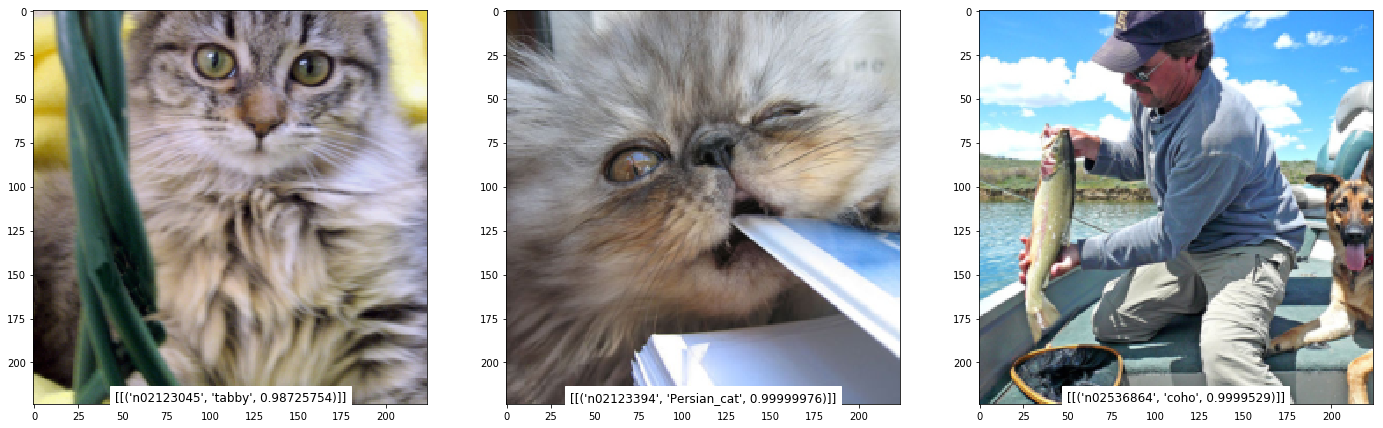

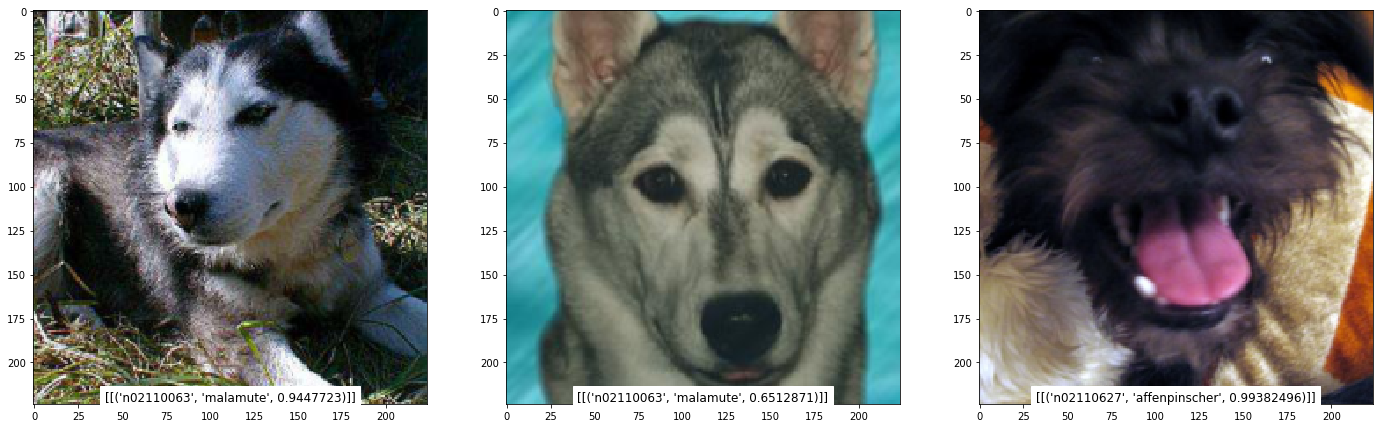

In [10]:
from keras.applications import inception_v3

inception = inception_v3.InceptionV3()

predictCategorical([1,2000,3000,4000,4300,4510], model=inception, decode=lambda x: inception_v3.decode_predictions(x, top=1))

# Transfer Learning

This network is very accurate, we only want to tell cats from dogs for now. Can we change it to only do this and to also focus on cats and dogs only?

One way in which it is better than our small network it that it it abre to generalize concepts bettee. It has learned to extract features from image which make up the things it knows. By replacing the top layer of the network by one we train ourselfes we can make use of the pre-trained network's ability to extract features to distinguish only the classes we want it to:

In [ ]:
# get the pre-trained inception_v3 network without its top layer
inception = inception_v3.InceptionV3(include_top=False
        , weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None)

# keep the pre-trained layers constant during training
for l in inception.layers:
    l.trainable = False
    
# add our own top
x = Flatten()(inception.output)
predictions=Dense(1, activation='sigmoid')(x)
modelInception = Model(outputs=predictions, inputs=inception.input)
modelInception.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# modelInception.summary()

# train using the same training and validation data as before
modelInception.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=8, batch_size=batch_size)

In [ ]:
# some arbitrary selection from the data
predict([1,2000,3000,4000,4300,4510], modelInception)

In [ ]:
# some of the training images
predict(range(9), modelInception, data=x_train, norm=None)

In [ ]:
# some of the validation images
predict(range(9), modelInception, data=x_test, norm=None)

### Databias

When preparing our dataset we did not include all dog-pictures. In fact, we happened to include only pictures of shepherds and huskies, while another breed was left. See how the inception-based model views these now:

In [ ]:
predict(range(4400, 4420), modelInception)